In [46]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from collections import defaultdict
import tensorflow as tf
import altair as alt
import collections

from src.utils import split_dataframe, CFModel
from src.load_data import read_tables
from src.Baseline_Model import build_baseline_model


In [2]:
reviews = pd.read_csv('data/cleaned_reviews_mystery_1.csv')
books = pd.read_csv('data/cleaned_books_mystery_1.csv')
reviews.head()


# SAMPLE = False
# if SAMPLE:
#     N = 10000
#     reviews = reviews[(reviews['user_id']<N) & (reviews['book_id']<N)]
#     books = books[books['book_id'] < N]

In [3]:
def generate_dataset(reviews, books):
    MIN_GOOD_RATING = 4
    MAX_NUM_BOOKS_PER_USER = 20
    
    prev_good_books = defaultdict(set) # from user_id to a set of book_ids
    prev_bad_books = defaultdict(set)
    
    reviews['book_id'] = reviews['book_id'].astype(str)
    reviews['user_id'] = reviews['user_id'].astype(str)
    
    data = []
    reviews = reviews.sort_values(by=['timestamp'])
    for i in range(reviews.shape[0]):
        if i % 1000 == 0:
            print("\r processed %d rows " % i, end='')
        row = reviews.iloc[i]
        user_id = row['user_id']
        book_id = row['book_id']
        rating = row['rating']
        
        entry = {
            'user_id': user_id,
            'book_id': book_id,
            'rating': rating,
            'timestamp': row['timestamp'],
            'prev_good_books':  list(prev_good_books[user_id]), # make a copy for each example
            'prev_bad_books': list(prev_bad_books[user_id])
        }
        # TODO: remove this check
        # if len(prev_good_books[user_id]) > 0 and len(prev_bad_books[user_id]) > 0:
        data.append(entry)
        
        if rating >= MIN_GOOD_RATING and len(prev_good_books[user_id])< MAX_NUM_BOOKS_PER_USER:
            prev_good_books[user_id].add(book_id)
        elif rating < MIN_GOOD_RATING and len(prev_bad_books[user_id]) < MAX_NUM_BOOKS_PER_USER:
            prev_bad_books[user_id].add(book_id)
    return pd.DataFrame(data)

# dataset = generate_dataset(reviews, books)
# dataset.to_csv('data/dnn_dataset.csv', index=False)

In [24]:
dataset = pd.read_csv('data/dnn_dataset.csv')
import json
def load_str(x):
    return json.loads(x.replace("'", '"'))
dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: load_str(x))
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: load_str(x))
dataset['book_id'] = dataset['book_id'].astype(str)

book_id_vocab = dataset['book_id'].astype(str).unique()
dataset[:5]

,user_id,book_id,rating,timestamp,prev_good_books,prev_bad_books
0,102489,37120,3,2001-01-01 00:00:00,[],[]
1,102489,96299,3,2001-01-11 00:00:00,[],['37120']
2,102489,82887,4,2001-01-25 00:00:00,[],"['96299', '37120']"
3,102489,85615,2,2001-01-29 00:00:00,['82887'],"['96299', '37120']"
4,102489,50050,4,2001-02-02 00:00:00,['82887'],"['85615', '96299', '37120']"


In [28]:
#limit to 2 previously liked and disliked books
dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: x[:2])
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: x[:2])

In [45]:
dataset.tail(10)

,user_id,book_id,rating,timestamp,prev_good_books,prev_bad_books
1551755,89814,94295,5,2017-11-03 14:11:08,"[3410, 17493]",[]
1551756,89814,16987,5,2017-11-03 14:11:41,"[3410, 17493]",[]
1551757,89814,80971,5,2017-11-03 14:12:33,"[3410, 17493]",[]
1551758,89814,90006,5,2017-11-03 14:13:12,"[3410, 17493]",[]
1551759,89814,90005,5,2017-11-03 14:14:07,"[3410, 17493]",[]
1551760,95989,59221,3,2017-11-03 14:50:16,"[62313, 46824]",[65024]
1551761,12115,80157,5,2017-11-03 17:29:55,"[51915, 76169]",[]
1551762,46579,75852,4,2017-11-03 18:42:32,"[87118, 55945]","[14280, 62583]"
1551763,34243,78523,5,2017-11-03 21:12:55,"[56919, 44229]",[]
1551764,71677,82113,3,2017-11-03 22:17:08,"[13821, 83396]",[22731]


In [38]:
train_dataset, test_dataset = split_dataframe(dataset)

In [39]:
train_dataset.head()

,user_id,book_id,rating,timestamp,prev_good_books,prev_bad_books
0,102489,37120,3,2001-01-01 00:00:00,[],[]
1,102489,96299,3,2001-01-11 00:00:00,[],[37120]
2,102489,82887,4,2001-01-25 00:00:00,[],"[96299, 37120]"
3,102489,85615,2,2001-01-29 00:00:00,[82887],"[96299, 37120]"
4,102489,50050,4,2001-02-02 00:00:00,[82887],"[85615, 96299]"


In [40]:
def make_batch(ratings, batch_size):
    """Creates a batch of examples.
    Args:
        ratings: A DataFrame of ratings such that examples["book_id"] is a list of
        books rated by a user.
    batch_size: The batch size.
    """
    def pad(x, fill):
        return pd.DataFrame.from_dict(x).fillna(fill).values

    features = {
      "prev_good_books": pad(ratings['prev_good_books'].values.tolist(), ""),
      "prev_bad_books": pad(ratings['prev_bad_books'].values.tolist(), ""),        
      "rating": ratings['rating'].values,
       "book_id": ratings['book_id'].values,
      }
    print('make_batch#3')    
    batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
    print('make_batch#4')    
    return batch


In [41]:
def make_shared_embedding_col(keys, shared_name, vocabulary_list, embedding_dim):
    columns = []
    for key in keys:
        columns.append(tf.feature_column.categorical_column_with_vocabulary_list(
            key, vocabulary_list, num_oov_buckets=0))

    return tf.feature_column.shared_embedding_columns(
        columns, shared_embedding_collection_name=shared_name, dimension=embedding_dim)
    
def mean_square_error_loss(batch_user_embeddings, book_embeddings, batch_book_ids, labels):
    user_emb_dim = batch_user_embeddings.shape[1].value
    book_emb_dim = book_embeddings.shape[1].value
    if user_emb_dim != book_emb_dim:
        raise ValueError('The user embedding dimension %d should match the book embedding dimension %d' %(
                user_emb_dim, book_emb_dim))
        
    batch_book_embeddings = tf.gather(book_embeddings, tf.strings.to_number(batch_book_ids, out_type=tf.dtypes.int32))
    
    batch_predictions = tf.reduce_sum(
        batch_user_embeddings * batch_book_embeddings, axis=1)
    
    loss = tf.compat.v1.losses.mean_squared_error(labels, batch_predictions)
    return loss

def build_dnn_model(train_dataset, test_dataset, embedding_cols, hidden_dims, learning_rate =1,):
    print('build_dnn_model#1')
    def create_network(features):
        #create a bog-of-words embedding for each sparse feature
        inputs = tf.feature_column.input_layer(features, embedding_cols)
        #hidden layer
        input_dim = inputs.shape[1].value
        for i, output_dim in enumerate(hidden_dims):
            w = tf.get_variable(
                'hidden%d_w_'% i, shape=[input_dim, output_dim],
                initializer=tf.truncated_normal_initializer(
                stddev=1./np.sqrt(output_dim)))/10
            outputs = tf.matmul(inputs, w)
            input_dim = output_dim
            inputs = outputs
        return outputs
    
    print('build_dnn_model#2')    
    train_batch = make_batch(train_dataset, 200)
    test_batch = make_batch(test_dataset, 100)
    print('build_dnn_model#3')    
    with tf.variable_scope('model', reuse=False):
        #train
        train_user_embeddings =create_network(train_batch)
        train_labels = train_batch['rating']
        train_book_ids = train_batch['book_id']
        
    with tf.variable_scope('model', reuse=True):
        #test
        test_user_embeddings = create_network(test_batch)
        test_labels = test_batch['rating']
        test_book_ids = test_batch['book_id']
        
        book_embeddings = tf.get_variable("input_layer/book_id_embedding/embedding_weights")
        
    print('build_dnn_model#4')        
    train_loss = mean_square_error_loss(train_user_embeddings, book_embeddings, train_book_ids, train_labels)
    test_loss = mean_square_error_loss(test_user_embeddings, book_embeddings, test_book_ids, test_labels)
    
#     _, test_prediction_at_10 = tf.metrics.precision_at_k(
#         labels=test_labels, predictions=tf.matmul(test_user_embeddings, book_embeddings, transpose_b=True),
#         k=10)
    
    metrics=(
        {'train_loss': train_loss, 'test_loss': test_loss},
        {},
        # {'test_precision_at_10': test_prediction_at_10}
    )
    embeddings = {'book_id': book_embeddings}
    return CFModel(embeddings, train_loss, metrics, learning_rate=learning_rate)


with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                book_id_vocab, 5)
             #make_embedding_col('author_id',10),
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model = build_dnn_model(
        train_dataset, test_dataset, 
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    


embedding_cols start
embedding_cols done
build_dnn_model#1
build_softmax_model#2
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_softmax_model#3
build_softmax_model#4
_train_init

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
_train_init done


 iteration 9998: train_loss=2.654268, test_loss=4.0679687

No handles with labels found to put in legend.


 iteration 10000: train_loss=3.287401, test_loss=4.628767

({'train_loss': 3.2874012, 'test_loss': 4.628767}, {})

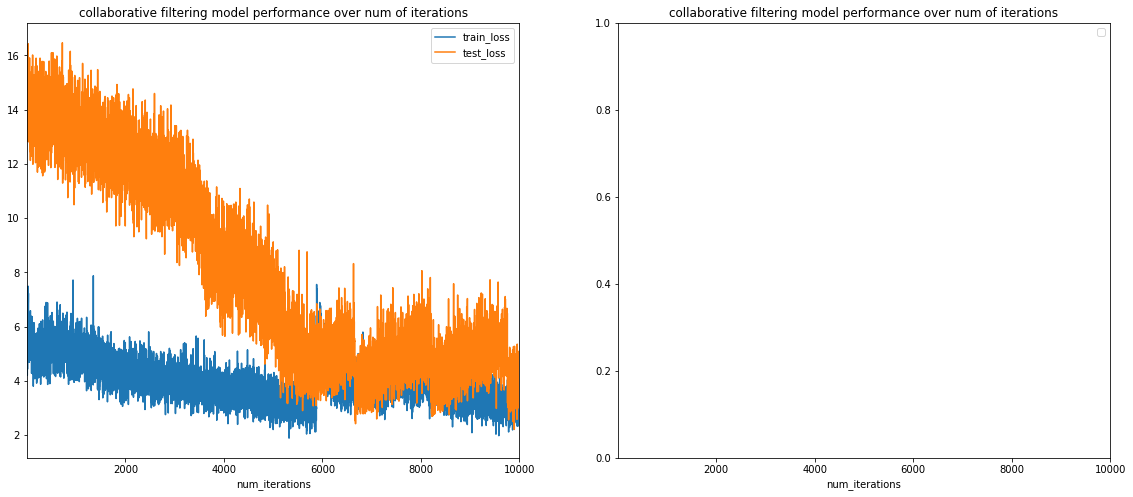

In [44]:
dnn_model.train( num_iterations =10000)